# Looking for patterns in grand mal seizures

**Author:** James Twose <br>
**Date:** 20-03-2021 <br>

Context
====

This data set is 12 months of seizure frequency data of a 20 year old male that lives in Iowa City, Iowa. He sufferers from grand mal seizures that result from Tubular Sclerosis that affects his brain. This is my nephew Michael, and I love him, and I want to access the smartest and best data resources to help provide insight and maybe support that can give him some relief.

I am providing this data in hopes of creating a contest that can help identify and predict a pattern to his seizures based on this frequency data and state (sleep/awake), and environmental data including weather, allergens, temperature, and other potential sources.

About Tubular Sclerosis
===
Tubular Sclerosis is an uncommon genetic disorder that causes noncancerous (benign) tumors — unexpected overgrowths of normal tissue — to develop in many parts of the body.

In [1]:
# utility packages
from sinfo import sinfo

# data manipulation packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#analysis packages
from scipy.spatial import distance_matrix

from jmspack.NLTSA import (ts_levels, 
                           distribution_uniformity, 
                           fluctuation_intensity, 
                           complexity_resonance, 
                           complexity_resonance_diagram,
                          cumulative_complexity_peaks,
                          cumulative_complexity_peaks_plot)

from dtw import dtw, rabinerJuangStepPattern

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
sinfo(write_req_file=False)

-----
dtw         1.1.6
jmspack     0.0.2
matplotlib  3.3.4
numpy       1.19.2
pandas      1.2.3
pyrqa       NA
scipy       1.6.1
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.23.2
-----
IPython             7.21.0
jupyter_client      6.1.7
jupyter_core        4.7.1
jupyterlab          3.0.10
notebook            6.2.0
-----
Python 3.8.8 (default, Feb 24 2021, 13:46:16) [Clang 10.0.0 ]
macOS-10.16-x86_64-i386-64bit
12 logical CPU cores, i386
-----
Session information updated at 2021-03-21 21:16


In [3]:
interesting_weather_columns = ['NAME', 'SNOW', 'PRCP',
 'TMAX',
 'TMIN',
 'timestamp']

In [4]:
weather_df = (pd.read_csv("iowa_weather.csv")
              .assign(timestamp = lambda x : pd.to_datetime(x["DATE"]))
             .loc[:, interesting_weather_columns]
             )

In [5]:
mal_df = (pd.read_excel("MB_SeizureRecords.xlsx", index_col=0)
          .loc[1:72, :]
          .assign(timestamp = lambda x : pd.to_datetime(x["DATE"]))
          .loc[:, ["timestamp", "STATE"]]
          .reset_index(drop=True)
          .assign(grand_mal = 1)
         )

mal_df.columns = [x.lower() for x in mal_df.columns]

In [6]:
all_times = pd.date_range(mal_df["timestamp"].min(),
                          mal_df["timestamp"].max(), freq = "d")

In [7]:
troublesome_ts = (mal_df
 .groupby("timestamp")
 .count()
 .loc[:, "grand_mal"]
 .sort_values(ascending=False)
 .head(9)
 .index
 .tolist()
)

In [8]:
both_ts = (mal_df[mal_df["timestamp"].isin(troublesome_ts)]
 .value_counts()
 .reset_index()
 .groupby("timestamp")
 .count()
 .sort_values("state")
 .tail(4)
 .index
 .tolist()
)

In [9]:
mals = (mal_df
 .groupby("timestamp")
 .count()
 .loc[:, ["grand_mal"]]
)

states = (mal_df
 .groupby("timestamp")
 .head(1)
 .set_index("timestamp")
 .loc[:, ["state"]]
)

_df = pd.merge(mals, states, left_index=True, right_index=True)

_df.loc[both_ts, "state"] = "both"

In [10]:
_df = _df.reindex(all_times)

In [11]:
_df.loc[_df["grand_mal"].isna(), "grand_mal"] = 0

In [12]:
df = pd.merge(_df, 
         weather_df[weather_df["NAME"].str.contains("IOWA CITY, IA US")],
         how="left",
         left_index=True,
         right_on="timestamp"
        ).set_index("timestamp")

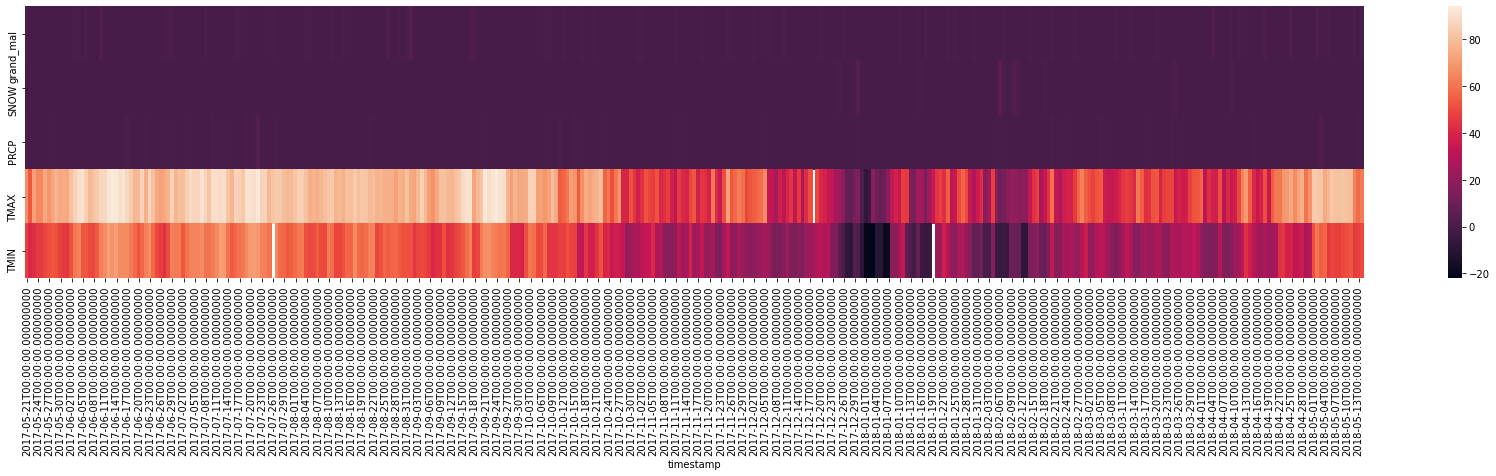

In [13]:
_ = plt.figure(figsize=(30, 5))
_ = sns.heatmap(df.drop(["state", "NAME"], axis=1).T)

## RQA plotting

In [14]:
scale_cols = interesting_weather_columns[1:-1] + ["grand_mal"]

In [15]:
scale_cols

['SNOW', 'PRCP', 'TMAX', 'TMIN', 'grand_mal']

In [33]:
# for feature in scale_cols:
# # feature = "grand_mal"
# # feature = "TMIN"

#     data_points = df[feature].values.tolist()

#     time_series = TimeSeries(data_points,
#                              embedding_dimension=1,
#                              time_delay=1)
#     settings = Settings(time_series,
#                         analysis_type=Classic,
#                         neighbourhood=FixedRadius(0.65),
#                         similarity_measure=EuclideanMetric,
#                         theiler_corrector=1)
#     computation = RQAComputation.create(settings,
#                                         verbose=False)
#     result = computation.run()

#     computation = RPComputation.create(settings)
#     result = computation.run()
#     ImageGenerator.save_recurrence_plot(result.recurrence_matrix_reverse,
#                                         f'Img/{feature}_recurrence_plot.png')

## TS_levels

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2017-05-21 to 2018-05-14
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   grand_mal  359 non-null    float64
 1   state      60 non-null     object 
 2   NAME       359 non-null    object 
 3   SNOW       359 non-null    float64
 4   PRCP       359 non-null    float64
 5   TMAX       358 non-null    float64
 6   TMIN       357 non-null    float64
dtypes: float64(5), object(2)
memory usage: 30.5+ KB


In [18]:
def scale_df(x):
    return pd.DataFrame(MinMaxScaler().fit_transform(x), columns=x.columns, index=x.index)

In [19]:
df[scale_cols] = scale_df(df[scale_cols])

In [20]:
feature_selection = scale_cols #+ ["grand_mal"]
ts_df = df.drop(["state", "NAME"], axis=1).dropna().reset_index()

In [21]:
all_ts_levels = pd.DataFrame()
for column in feature_selection:
    ts_levels_df, fig, ax = ts_levels(ts=ts_df[column], 
                                  ts_x=None, 
                                  criterion="mse", 
                                  max_depth=10, 
                                  min_samples_leaf=15,
                                  min_samples_split=2, 
                                  max_leaf_nodes=30, 
                                  plot=False, 
                                  equal_spaced=True, 
                                  n_x_ticks=10)
    _ = ts_levels_df.set_index("t_steps", inplace=True)
    ts_levels_df.columns = [f"{column}_{x}" for x in ts_levels_df.columns.tolist()]
    all_ts_levels = pd.concat([all_ts_levels, ts_levels_df], axis=1)

In [22]:
plot_df = (pd.merge(ts_df["timestamp"].reset_index(drop=True), 
         all_ts_levels, 
         left_index=True, 
         right_index=True)
       .melt(id_vars="timestamp"))

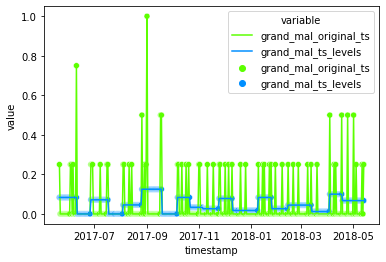

In [23]:
ax = sns.scatterplot(x="timestamp", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("grand_mal")],
                 )
ax = sns.lineplot(x="timestamp", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("grand_mal")],
                 )

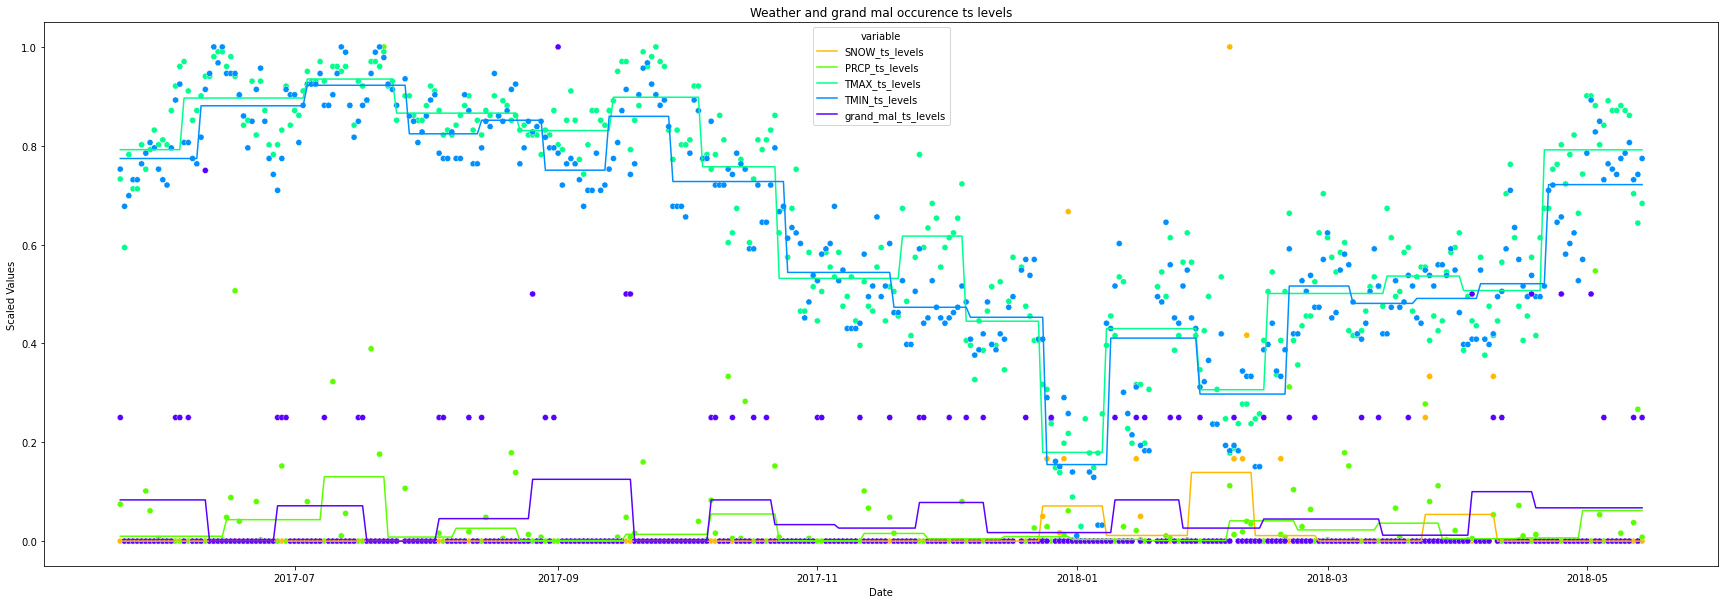

In [24]:
plt.figure(figsize=(30, 10))
height=1
ax = sns.scatterplot(x="timestamp", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("original_ts")],
                  legend=False,
                  linestyle='dashed',
                 )
ax = sns.lineplot(x="timestamp", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("ts_levels")],
                 )
_ = ax.set(xlabel='Date', ylabel='Scaled Values', 
           title=f'Weather and grand mal occurence ts levels')

## Dynamic time warping of ts levels time series

In [25]:
template = plot_df[plot_df["variable"].str.contains("grand_mal_ts_levels")].value.values
query = plot_df[plot_df["variable"].str.contains("PRCP_ts_levels")].value.values

# template = plot_df[plot_df["variable"].str.contains("TMAX_ts_levels")].value.values
# query = plot_df[plot_df["variable"].str.contains("TMIN_ts_levels")].value.values

# template = plot_df[plot_df["variable"].str.contains("TMAX_ts_levels")].value.values
# query = plot_df[plot_df["variable"].str.contains("TMAX_ts_levels")].value.values

In [26]:
len(query), len(template)

(356, 356)

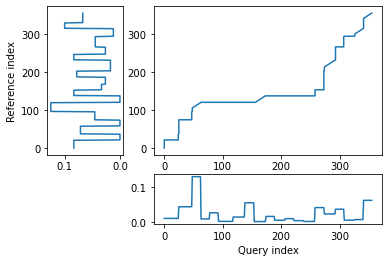

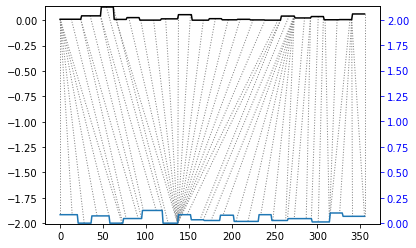

10.25423849434186

In [27]:
## Find the best match with the canonical recursion formula
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
_ = alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(1, "c"))\
    .plot(type="twoway",offset=-2)

# ## See the recursion relation, as formula and diagram
# print(rabinerJuangStepPattern(6,"c"))
# rabinerJuangStepPattern(6,"c").plot()

alignment.distance

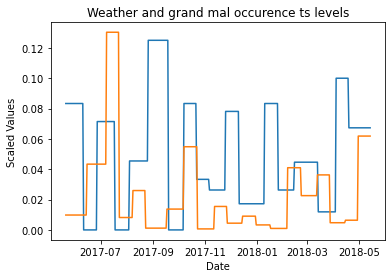

In [28]:
ax = sns.lineplot(x="timestamp", 
                  y="value",
#                   hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("grand_mal_ts_levels")],
                 )

ax = sns.lineplot(x="timestamp", 
                  y="value",
#                   hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("PRCP_ts_levels")],
                 )

_ = ax.set(xlabel='Date', ylabel='Scaled Values', 
           title=f'Weather and grand mal occurence ts levels')

## Dynamic Complexity

In [29]:
fluctuation_intensity_df = fluctuation_intensity(df=ts_df.set_index("timestamp"), 
                                                  win=7, 
                                                  xmin=0, 
                                                  xmax=1, 
                                                  col_first=1, 
                                                  col_last=ts_df.shape[1]-1)

distribution_uniformity_df = distribution_uniformity(df=ts_df.set_index("timestamp"), 
                                                  win=7, 
                                                  xmin=0, 
                                                  xmax=1, 
                                                  col_first=1, 
                                                  col_last=ts_df.shape[1]-1)

complexity_resonance_df = complexity_resonance(fluctuation_intensity_df, distribution_uniformity_df)

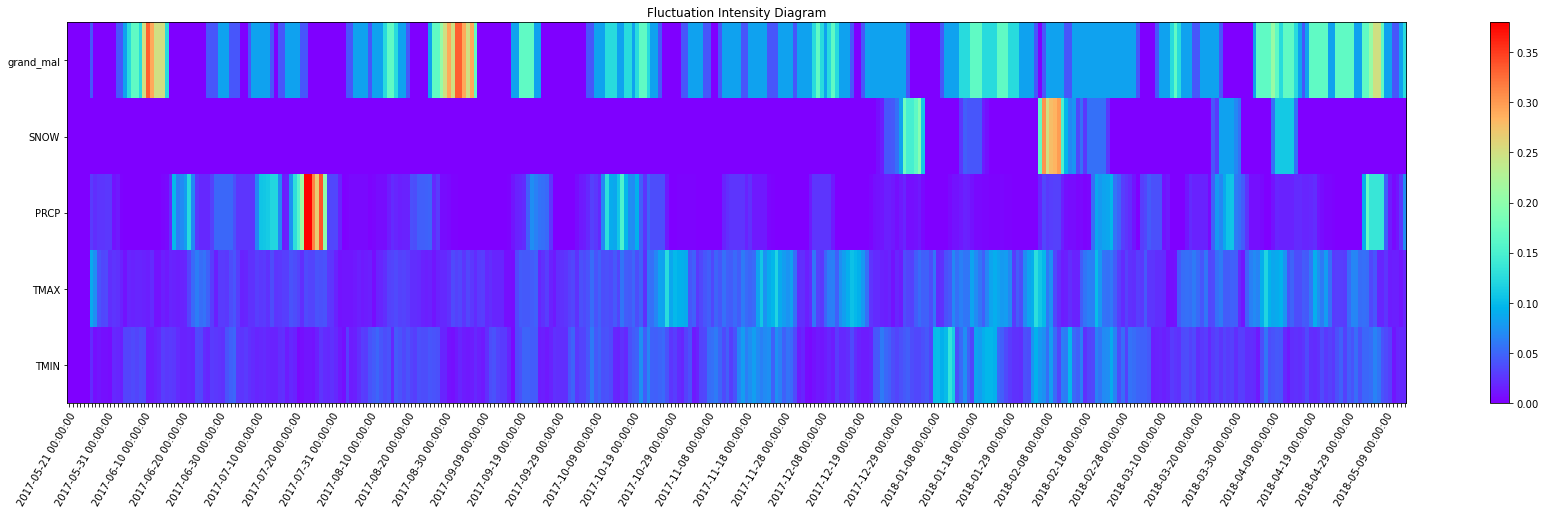

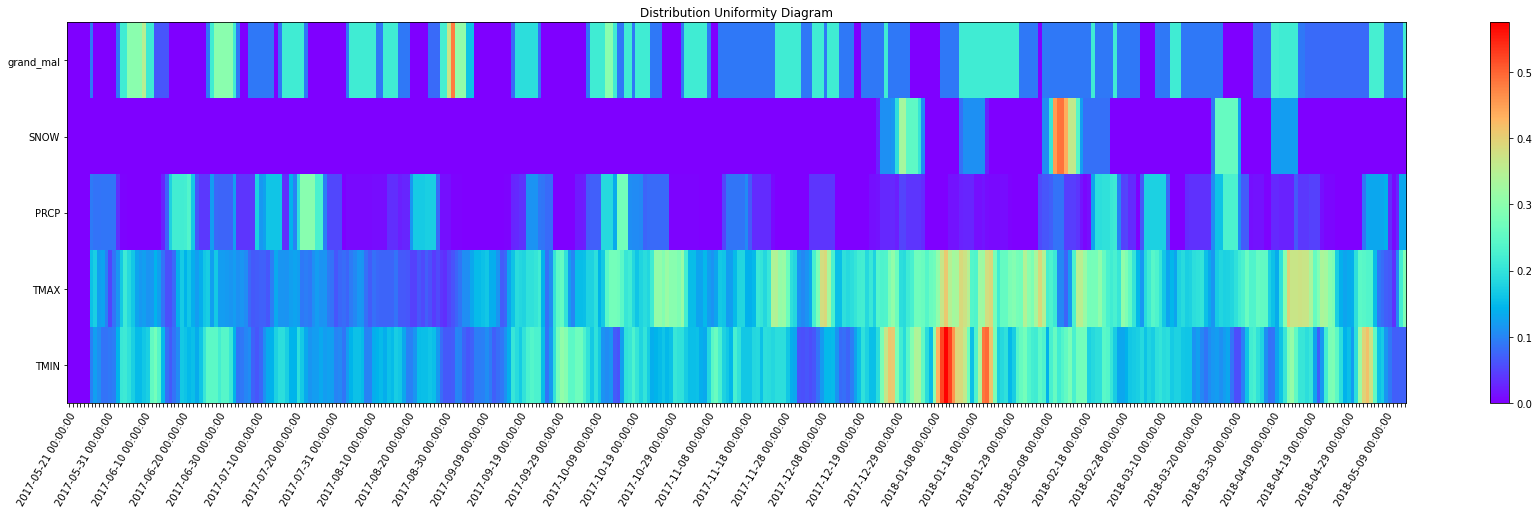

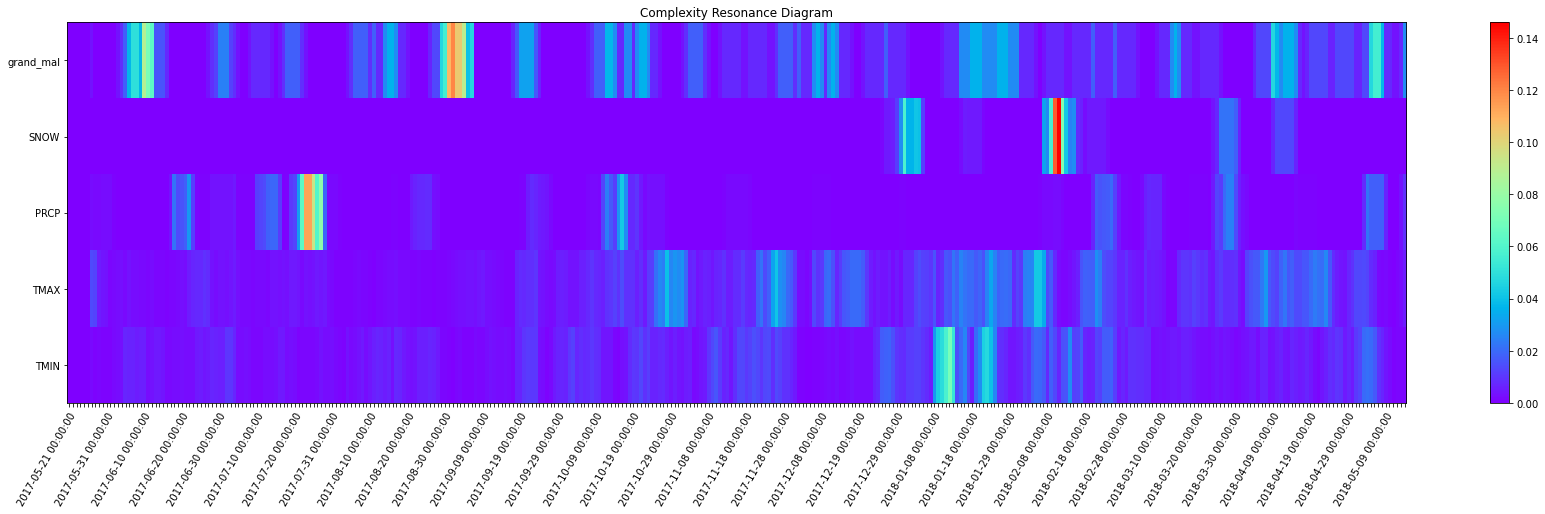

In [30]:
_ = complexity_resonance_diagram(fluctuation_intensity_df, plot_title='Fluctuation Intensity Diagram', figsize=(30, 7))
_ = complexity_resonance_diagram(distribution_uniformity_df, plot_title='Distribution Uniformity Diagram', figsize=(30, 7))
_ = complexity_resonance_diagram(complexity_resonance_df, figsize=(30, 7))

In [31]:
cumulative_complexity_peaks_df, significant_peaks_df = cumulative_complexity_peaks(df=complexity_resonance_df,
                            significant_level_item = 0.001,
                            significant_level_time = 0.05,)

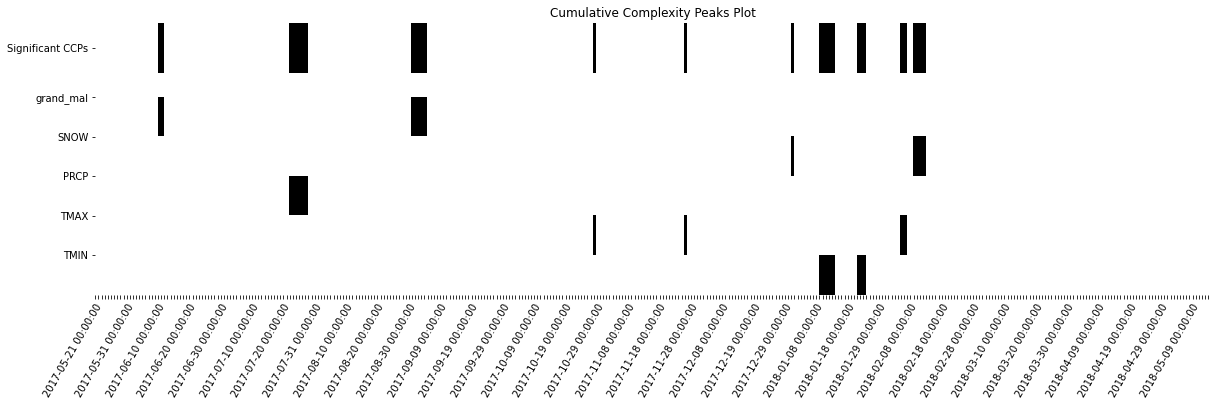

In [32]:
_ = cumulative_complexity_peaks_plot(cumulative_complexity_peaks_df, 
                                     significant_peaks_df,
                                    figsize=(20,5),
                                    height_ratios=[1,4])